# Import Libraries 

In [1]:
%%time

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import os
import shutil
import os.path
import time
import pandas as pd
from datetime import date
#from rembg import remove #removes the background from an image
import imutils
import re

# COMMON LIBRARIES
import json, random
import torch, detectron2
import pickle

#from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

#Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

CPU times: total: 3.45 s
Wall time: 3.49 s


<Logger detectron2 (DEBUG)>

In [2]:
today = date.today()
format = '%Y-%m-%d'
string = today.strftime(format)
print("Today's date:", string)

Today's date: 2025-07-09


# set object detection to the appropriate object filter.  Just for testing right now.  Will eventually go away
#######################3Add prompt for user entry###########################################33

#1 hp and 2 rtb
#3 is SHB
#4 is SHP
#5 is YTB

#prompt user to enter object they are tracking
print("Enter: \n 1-hockey puck\n 2-red tennis ball\n 3-street hockey ball\n 4-street hockey puck\n 5-yellow tennis ball\n")
objecttest = input()
#print(objecttest)

objnum = int(objecttest)
#print(objnum)


In [3]:
#######################3Add prompt for user entry###########################################33

#1 hp and 2 rtb #3 is SHB #4 is SHP #5 is YTB

#prompt user to enter object they are tracking 
print("Enter: \n 1-hockey puck\n 2-red tennis ball\n 3-street hockey ball\n 4-street hockey puck\n 5-yellow tennis ball\n") 
objecttest = input() #print(objecttest)

objnum = int(objecttest) #print(objnum)

Enter: 
 1-hockey puck
 2-red tennis ball
 3-street hockey ball
 4-street hockey puck
 5-yellow tennis ball



 1


# Define Functions

In [4]:
#function to calculate distance across object in pixels and state if there was an error or not.

def objectpixs(image):
    
    #img = image #'C:/Users/adamb/Documents/Slapper_Tracker/roi/roi13.jpg'
    imgtest = image.copy() #changed to copy 4/28/24
  
    # convert image to gray scale image 
    gray = cv2.cvtColor(imgtest, cv2.COLOR_BGR2GRAY) 
  
    # detect corners with the goodFeaturesToTrack function. 
    corners = cv2.goodFeaturesToTrack(gray, 2, 0.01, 10)

    if corners is None: #if there are no corners go through and assign points to width of the frame
        show_img(imgtest)
        print(gray.shape)
        error = "no_corners" #0 means there were no corners detected
        point1x = 0
        point1y = 0
        point2x = gray.shape[0]
        point2y = 0

        # initializing points in
        # numpy arrays
        point1 = np.array((point1x, point1y))
        point2 = np.array((point2x, point2y))
 
        # calculating Euclidean distance
        # using linalg.norm()
        dist = np.linalg.norm(point1 - point2)
 
        # printing Euclidean distance
        #print(dist)
    

    else: #if two corners, use them to calculate euclidean distance.
        corners = np.intp(corners)
        error = "none"
        #print(corners)

        pointx = [] #create list for x points
        pointy = [] #create list for y points

    # we iterate through each corner,  
    # making a circle at each point that we think is a corner. 
        for i in corners: 
            x, y = i.ravel() 
            cv2.circle(imgtest, (x, y), 3, 255, -1)
            pointx.append(x) #append list with point x number
            pointy.append(y) #append list with point y number
    

        Pointxseries=pd.Series(pointx, name='X Points') #create series for results from loop
        Pointyseries=pd.Series(pointy, name='Y Points') #create series for results from loop


        Pointsdf=pd.concat([Pointxseries, Pointyseries], axis=1) #concactanate the series into a dataframe

        show_img(imgtest)
        print(gray.shape)
        #print(Pointsdf.head())

        point1x = Pointsdf.loc[0, 'X Points']
        point1y = Pointsdf.loc[0, 'Y Points']
        point2x = Pointsdf.loc[1, 'X Points']
        point2y = Pointsdf.loc[1, 'Y Points']

    # initializing points in
    # numpy arrays
        point1 = np.array((point1x, point1y))
        point2 = np.array((point2x, point2y))
 
    # calculating Euclidean distance
    # using linalg.norm()
        dist = np.linalg.norm(point1 - point2)
 
    # printing Euclidean distance
        #print(dist)

##########error handling for too small of points.  If the euclidean distance is less than half the frame, make the distance equal to
    ###############the width of the image

    if dist < .7*gray.shape[0]:  #.65
        dist = gray.shape[0]
        error = "Too_small"

    return dist, error, point1x, point1y, point2x, point2y

In [5]:
#function to concactonate dataframes and drop file paths and rename with filename in filepaths.

def conc_and_rename(dfexisting, dfnew):

#error handling-If file doesn't exist I don't want to do this.
    if 'filename' not in dfnew:
        frames = [dfexisting, dfnew]
        concattestdf=pd.concat(frames)
        concattestdf=concattestdf.reset_index(drop=True)
    else:
        dftest=dfnew.drop(['filepaths'], axis=1)#drop filepaths from df and 
        #dftest1=dftest.rename(columns={"file": "filepaths"})#rename file to filepaths
        test = dftest #was dftest1
        frames = [dfexisting, test]
        concattestdf=pd.concat(frames)
        concattestdf=concattestdf.reset_index(drop=True)

    concattestdf.head(20)

    return concattestdf

In [6]:
#function to display image

def show_img(img):
  fig = plt.gcf()
  fig.set_size_inches(8, 4) #was 16 and 8
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [7]:
#function to split the path from the file of the image and the file name to reveal the frame number to use with time.
#this will change in an app when it is selected as the file path won't be there.

def time_stamp(path):
    test, testext = os.path.splitext(path) #remove file extension from frame1
    frame1path1, frame1file = os.path.split(test) #remove path from filename
    t = frame1file[15:] #remove the first 15 characters from the frame1file
    tnum = int(t)
    return tnum

In [8]:
#Function to take image, produce outputs, and draw predictions

##################Need to do something for two or more objects in a frame#########################

def inference(img):
    outputs = predictor(img)

    #look at outputs
    object = outputs["instances"].pred_classes
    boxes = outputs["instances"].pred_boxes
    scores = outputs["instances"].scores

##############Remove this as it is not needed, used for troubleshooting#########
    #Visualize results
#    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
#    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#    plt.figure(figsize = (14, 10))
#    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

#    print(object)
#    print(boxes)
#    print('Scores:',scores)
    
    ###################################################################################This worked, need to determine how to filter.
#Also going to have to filter out any objects outside of this.  Thinking take the object closest to center of image.  Filter out all else
#then create mask for the objects filtered out and then pass this mask to image two to filter out the object not of interest.
#sounds good, but need to think about how to actually do it.
#Just for testing at this point.  Need to clean up later after I work through this.

    idxofClass = [i for i, x in enumerate(list(outputs['instances'].pred_classes)) if x == objnum] #was 2

    classes = outputs["instances"].pred_classes[idxofClass]
    scores = outputs["instances"].scores[idxofClass]
    boxes = outputs["instances"].pred_boxes[idxofClass]

    obj = detectron2.structures.Instances(image_size=(480, 640)) #size was 480, 640 this took over a second off going to 120/160. Then 1/1.33 back to 12.5 

    obj.set('pred_classes', classes)
    obj.set('scores', scores)
    obj.set('pred_boxes', boxes)

    #out = v.draw_instance_predictions(obj.to("cpu"))
    
####4/6/24 comment out to see how it affects inference time.  Was performing 2 inferences at 12.4 seconds. went to 12.1 seconds.
    #######not much of improvement
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
    v = v.draw_instance_predictions(obj.to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

################################################################################################

    #Define the coordintates for the object

    #########################################################################################
    ####           Testing for no inference 5/29/24
    ####

    y = boxes.tensor.numpy() #convert tensor to array for bounding boxes
    #print(y)
    #print(len(y))
    
    #if (len(y) == 0):
        #x1 = 0
        #x2 = img.shape[1]
        #y1 = 0
        #y2 = img.shape[0]

    #else:
  
    x1 = y[0][0]
    x2 = y[0][2]
    y1 = y[0][1]
    y2 = y[0][3]

    print(x1, x2, y1, y2)

    #area of bounding box

    width = abs(x1-x2) #pixels
    height = abs(y1-y2) #pixels
    area = width * height #pixels squared
    print(width, height, area)

######Can add a check for accuracy or puck on edge by comparing width and height.  For ball they should be close, for puck it could be on edge.

   
############Need to product tensor value and assign object based on dataframe above.############################
    #make the object tensor a number for further analysis.
    ob = object.numpy() #convert object to array for classes
    obj = ob[0]
    print(obj)
  
    return x1, x2, y1, y2, width, height, area, obj

# Create dataframe or tuple for objects and size in inches

In [9]:
#Create dataframe with object and diameter in inches for each object.

#1 hp and 2 rtb
#3 is SHB
#4 is SHP
#5 is YTB


d = {'Object':['OTHER', 'HP', 'RTB', 'SHB','SHP','YTB'], 'Diameter': [0, 3, 3,2.625,3,2.7]}
df = pd.DataFrame(data=d)
df

,Object,Diameter
0,OTHER,0.000
1,HP,3.000
2,RTB,3.000
3,SHB,2.625
4,SHP,3.000
5,YTB,2.700


In [10]:
#test to select diameter based on index number
#dftest = df.loc[:,['Diameter']]
#Diameter = dftest.iloc[0] #number here is the index number
Diameter = df.loc[:,['Diameter']].iloc[1][0] #number in iloc location is the index number from tensor.
print(Diameter)

#df.loc[df['Diameter'] == value]

3.0


# Load Video

In [11]:
%%time
#import video

#pathtovideo = 'C:/Users/adamb/Documents/Slapper_Tracker/'#for other video
#testvideo = "PXL_20240128_154621033.TS.mp4" #me stick handling in basement
#pathtovideo = 'C:/Users/adamb/Documents/Slapper_Tracker/Videos/Need_to_Test'
pathtovideo = 'C:/Users/adamb/Documents/Slapper_Tracker/Videos/Need_to_Test'
#testvideo = "PXL_20240406_184026520.mp4"
testvideo = "PXL_20240406_184423926.mp4"

#join path and video file together
testvideo_new=os.path.join(pathtovideo, testvideo) #join path for video
cap = cv2.VideoCapture(testvideo_new)

#count number of frames
fps = cap.get(cv2.CAP_PROP_FPS) #this isn't accurate.  Should be 30.
frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) #get frame count for video
print(fps)
#print(testvideo_new)
#print(frames)

#################################Not sure I need any of this###########################################
cap.set(cv2.CAP_PROP_POS_AVI_RATIO, 1)
timemsec = cap.get(cv2.CAP_PROP_POS_MSEC)
#print(timemsec)

#take a frame every second


59.858389491009596
CPU times: total: 1.16 s
Wall time: 339 ms


# Setup model

In [12]:
%%script echo skipping
#%%time

##Full Detectron2 model

cfg = get_cfg()
cfg.MODEL.DEVICE='cpu' #set as cpu for pedictions
cfg.merge_from_file('C:/Users/adamb/Documents/Slapper_Tracker/output/test/config.yaml') #trying this from colab trained model 2/11/24
cfg.MODEL.WEIGHTS = os.path.join('C:/Users/adamb/Documents/Slapper_Tracker/output/Test/model', "model_final.pth") #trying this from colab trained model 2/11/24
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set the testing threshold for this model #was 0.7
#cfg.DATASETS.TEST = ("my_dataset_val", ) #was "balloon_val"
#cfg.MODEL.DEVICE='cpu' #set as cpu for pedictions
predictor = DefaultPredictor(cfg)

skipping


In [13]:
%%time
#load d2go model

#######################################Need .yaml from my model.  Figure out how to do this and it should work.

from d2go.model_zoo import model_zoo
from d2go.runner import GeneralizedRCNNRunner
#nc = 3
runner = GeneralizedRCNNRunner()

cfg = runner.get_default_cfg()
cfg.set_new_allowed(True)
cfg.merge_from_file("C:/Users/adamb/Documents/Slapper_Tracker/output/d2go/configd2go.yaml")#(model_zoo.get_config_file(model_url))
cfg.MODEL.WEIGHTS = "C:/Users/adamb/Documents/Slapper_Tracker/output/d2go/model_final.pth"
cfg.MODEL.DEVICE = "cpu" #if ('CI' in os.environ) else "cuda"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05   # set the testing threshold for this model #was 0.7
predictor = DefaultPredictor(cfg)


[2025-07-09 11:41:19,967] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
INFO:d2go.runner.default_runner:Initializing control pg
INFO:d2go.modeling.backbone.fbnet_v2:Using un-unified arch_def for ARCH "FBNetV3_A" (without scaling):
trunk
- [('conv_k3', 16, 2, 1), ('ir_k3', 16, 1, 2, {'expansion': 1}, {'less_se_channels': False})]
- [('ir_k5', 24, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5', 24, 1, 3, {'expansion': 3}, {'less_se_channels': False})]
- [('ir_k5_se', 32, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3_se', 32, 1, 3, {'expansion': 3}, {'less_se_channels': False})]
- [('ir_k5', 64, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3', 64, 1, 3, {'expansion': 3}, {'less_se_channels': False}), ('ir_k5_se', 112, 1, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5_se', 112, 1, 5, {'expansion': 3}, {'less_se_channels': False})]
rpn
- [('ir_k5_se', 

[07/09 11:41:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:/Users/adamb/Documents/Slapper_Tracker/output/d2go/model_final.pth ...


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from c:/Users/adamb/Documents/Slapper_Tracker/output/d2go/model_final.pth ...


CPU times: total: 3.84 s
Wall time: 3.93 s


# Pull two images from video

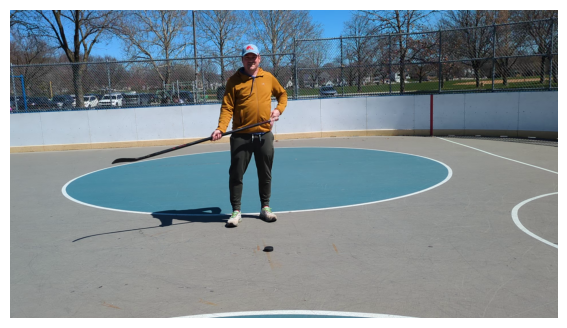

CPU times: total: 1.66 s
Wall time: 885 ms


In [14]:
%%time
#step one, pull first image of video and run inference on it for roi to pass to function to pull two frames.

cap = cv2.VideoCapture(testvideo_new)
cap.set(cv2.CAP_PROP_POS_FRAMES, 1) #take first frame of video
res, Frame1pic = cap.read()
show_img(Frame1pic)


In [15]:
#resizing image did not help with speed.  .5 second improvement a a little worse inference.

In [16]:
%%script echo skipping
##############This is a test remove after you figure out the model.

outputs = predictor(Frame1pic)

#look at outputs
object = outputs["instances"].pred_classes
boxes = outputs["instances"].pred_boxes
scores = outputs["instances"].scores

##############Remove this as it is not needed, used for troubleshooting#########
    #Visualize results
v = Visualizer(Frame1pic[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

print(object)
print(boxes)
print('Scores:',scores)

skipping


In [17]:
###########test to assign 0 in case inference isn't working

Frame1picobjectpixels = 0
frame1objectpixels = 0
frame2objectpixels = 0
Frame1picerror = 'No Inference'
frame1error = 'No Inference'
frame2error = 'No Inference'

C:\Users\adamb\anaconda3\envs\detectron_env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


874.5068 921.01904 816.9512 841.65515
46.512268 24.70398 1149.0381
1
CPU times: total: 1.02 s
Wall time: 1.07 s


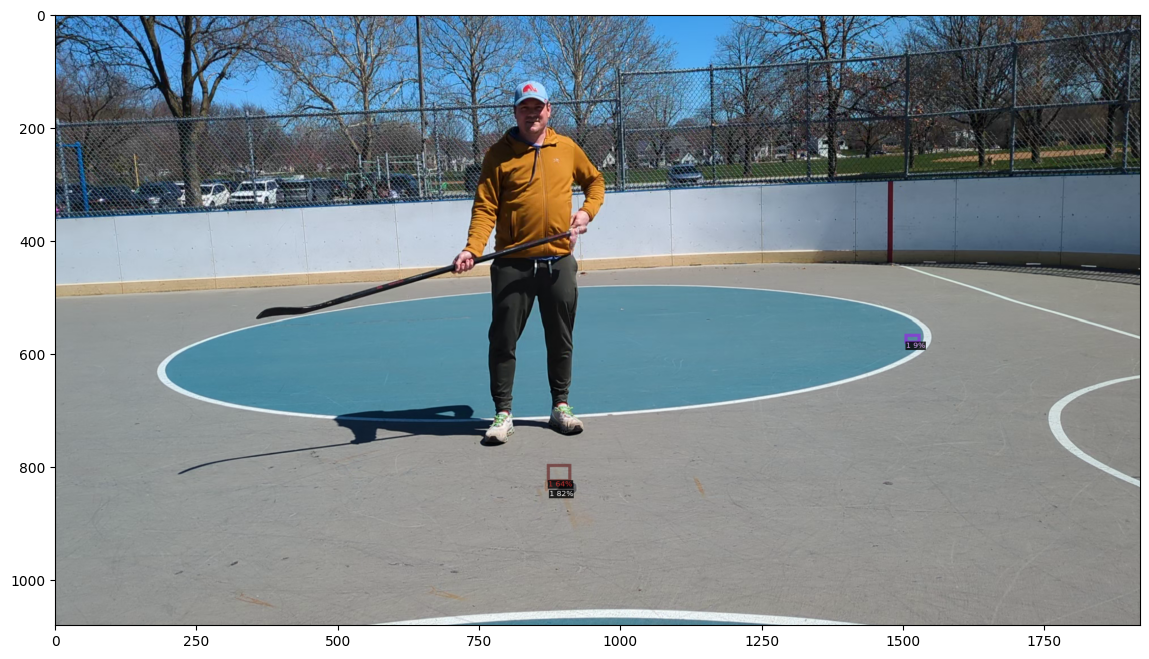

In [18]:
%%time
#run inference on first image

Frame1picx1, Frame1picx2, Frame1picy1, Frame1picy2, Frame1picwidth, Frame1picheight, Frame1oucarea, Frame1picobj = inference(Frame1pic)
#print(frame1x1, frame1x2, frame1y1, frame1y2, frame1width, frame1height, frame1area, frame1obj)



In [19]:
#print(frame1x1, frame1x2, frame1y1, frame1y2, frame1width, frame1height, frame1area, frame1obj)

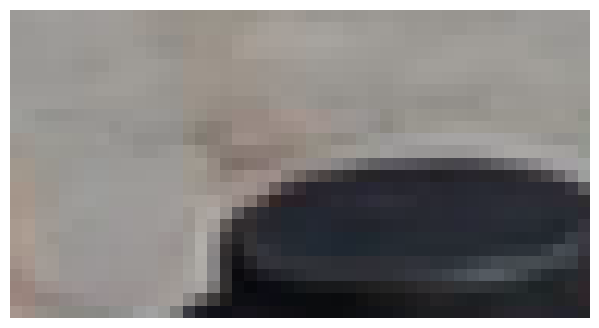

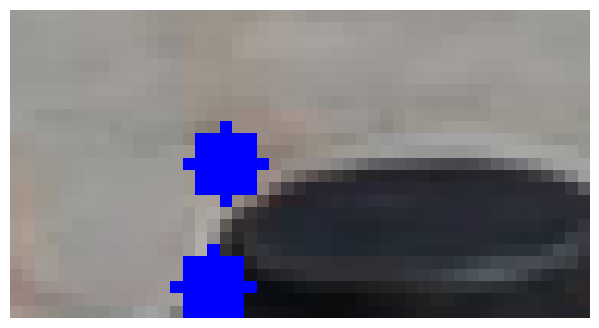

(25, 47)
816
841
874
921
CPU times: total: 172 ms
Wall time: 242 ms


In [20]:
%%time
#use new objectpics function to get pix for the object.

##############################################################################################3

#first need roi for Frame1pic

ROIFrame1pic = Frame1picx1, Frame1picx2, Frame1picy1, Frame1picy2
#print(ROIFrame1pic)

#turn ROI1 into image
x1, x2, y1, y2 = ROIFrame1pic
x11 =int(x1)
x22 =int(x2)
y11 =int(y1)
y22 =int(y2)
region_of_interestFrame1picROI = Frame1pic[y11:y22, x11:x22]
show_img(region_of_interestFrame1picROI)


#then need to run objectpics funtion

Frame1picobjectpixels, Frame1picerror, Frame1picpoint1x, Frame1picpoint1y, Frame1picpoint2x, Frame1picpoint2y = objectpixs(region_of_interestFrame1picROI)
print(y11)
print(y22)
print(x11)
print(x22)

#then use dataframe for pixs/inch

In [21]:
#Frame1pic.shape
#print(Frame1pic.shape[0])

In [22]:
#need to make this a function
#def checkforinference(img, y, x):
while ((y22 == Frame1pic.shape[0]) and  (x22 == Frame1pic.shape[1])):
    break

    #else:
        #print("good to go")

In [23]:
#checkforinference(Frame1pic, y22, x22)

Frame1


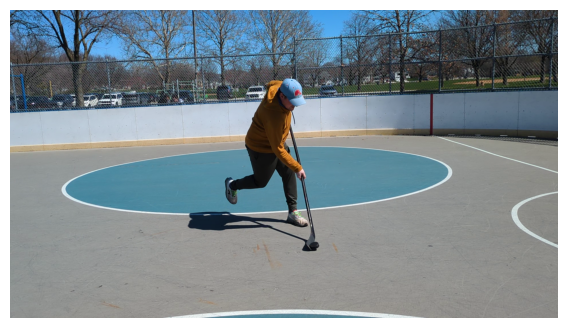

116
Frame2


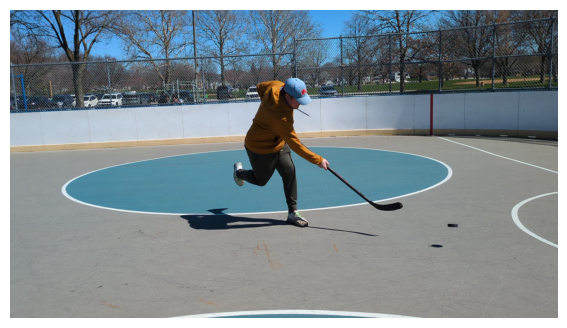

119
CPU times: total: 12.1 s
Wall time: 4.27 s


,Results,Frame
1,20.90383,frame116.jpg


In [24]:
%%time
#take roi from first image and use this for the basis of frame referencing for motion detection
#select two frames, high motion and one after it.


#if ((y22 == Frame1pic.shape[1]) and  (x22 == Frame1pic.shape[0])):
#    break

#else:

cap = cv2.VideoCapture(testvideo_new)
last_mean = 0
detected_motion = False
frame_rec_count = 0
framescount = cap.get(cv2.CAP_PROP_FRAME_COUNT) #get frame count for video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 120.0, (640, 480)) #(640, 480)
end = framescount-1
i=1
n=0 #used to count images that have motion.  After 2 are detected end loop.
frames = [] #list for adding the action frames to a df
results = [] #list for adding the motion number to the same df
#set ROI in image
    
#################Shrink ROI to better capture movement closer to puck##########################
#############shrinking roi didn't work, might need to use 60 fps video or switch pictures, frame 2 becomes frame1
#############and frame 2 is frame after new frame1
##################Need some work here##################################3
    
roi_top = int(Frame1picy1)
roi_bottom = int(Frame1picy2)
roi_right = int(Frame1picx1)
roi_left = int(Frame1picx2)
#Frame1pic[y11:y22, x11:x22]
    
while(True):
    ret, frame = cap.read()
    i+=1
    if i == end: #stop the loop before the last frame as there is no more to subtract and causes error.
        break # stop loop
        #grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #removed 4/7/24 #6.61 wall time without same speed
        #draw roi on image around hockey puck to look when it moves and use frame differencing.
        #show_img(frame)
    ROI = frame[roi_top:roi_bottom, roi_right:roi_left] #frame is color
        #############convert ROI to gray, then do frame differencing on roi
        #print('ROI')
        #show_img(ROI)
    gray = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)
        #show_img(gray)
    result = np.abs(np.mean(gray) - last_mean) #was gray; frame differencing, subtract the mean of the last one from the current frame.
        
        #roi = cv2.rectangle(gray, (roi_top, roi_bottom), (roi_right, roi_bottom), (0,0,255), 5) ###this is the whole image, need to take it down to just ROI
        #print('original roi')
        #show_img(roi) #########################uncommented for troubleshooting#############################33
        #result = np.abs(np.mean(roi) - last_mean) #frame differencing, subtract the mean of the last one from the current frame.
        #print(result)
    last_mean= np.mean(gray)
        #print(result)
    if result > 20: #need to play with this.  Was 20.
                #print("Motion detected!")
            #show_img(frame)
            #print('frame{:d}.jpg'.format(frame_rec_count))
        frameholder = 'frame{:d}.jpg'.format(frame_rec_count)
        frames.append(frameholder)
        results.append(result)
        cv2.imwrite(frameholder, frame) #save the motion image
            #print(frameholder)
        detected_motion = True
    
           
            #after finding two images end the loop, used to save time processing.
        n+=1
            #print(n)
        if n == 2:
            break
    if detected_motion:
        out.write(frame)
        frame_rec_count = frame_rec_count + 1
            
     
F1series=pd.Series(results, name='Results') #create series for results from loop
Fseries=pd.Series(frames, name='Frame') #create series for results from loop
    
motiondf=pd.concat([F1series, Fseries], axis=1) #concactanate the series into a dataframe
    
    #print(motiondf)
    
motiondf.drop(index=0, inplace = True) #remove first image from series
    #motiondf.drop(index=1, inplace = True) #remove 2nd image from series, this is where stick enters roi.  Similar to first image with differencing.
    
    
    #take max of results (motion) to determine selection
    
    ##############################Needs to be the first major referencing instead of max.#######################################
    #Take first image not max
Frame1 = motiondf['Frame'].iloc[0]
    #Frame1 = motiondf.loc[motiondf['Results'] == motiondf.Results.max(), 'Frame'].iloc[0] #produces frame number with most motion in string form
    #print(Frame1)
    
    #split Frame1 pic into image number and Frame, then add one to get the next frame for frame2
Frame1number = re.findall(r'\d+', Frame1)[0] #extract numbers only
    #print(Frame1number)
Frame1Noint = int(Frame1number) #convert string to integer
    
######################Probably need an adder of 1 if it is 30 fps on the camera, need testing########################################
    
    #create a string to use for next frame after frame1
Frame2number = Frame1Noint + 3
    #print(Frame2number)
    
    #assign frame 1 and 2 and show images
    
cap.set(cv2.CAP_PROP_POS_FRAMES, Frame1Noint)
res, Frame1 = cap.read()
Frame2pic = cap.set(cv2.CAP_PROP_POS_FRAMES, Frame2number)
res, Frame2 = cap.read()
    
print("Frame1")
#print(Frame1pic)
show_img(Frame1)
print(Frame1Noint)
    
print("Frame2")
show_img(Frame2)
print(Frame2number)
    
motiondf.head()
    
#issue that it got the last frames where I stepped into the roi.  Need to resolve this.

In [25]:
#troubleshooting
motiondf.head(300)
#motiondf.Results.max()
max = motiondf.loc[motiondf['Results'] == motiondf.Results.max(), 'Frame']
print(max)
print(motiondf.Results.max())
#puck = motiondf.loc[motiondf['Frame'] == 'frame54.jpg', 'Reuslts']
#print(puck)
motiondf.head(300)

1    frame116.jpg
Name: Frame, dtype: object
20.90382978723403


,Results,Frame
1,20.90383,frame116.jpg


1040.8015 1083.2332 826.68823 851.6336
42.43164 24.945374 1058.4731
1
1040.8015 1083.2332 826.68823 851.6336 42.43164 24.945374 1058.4731 1


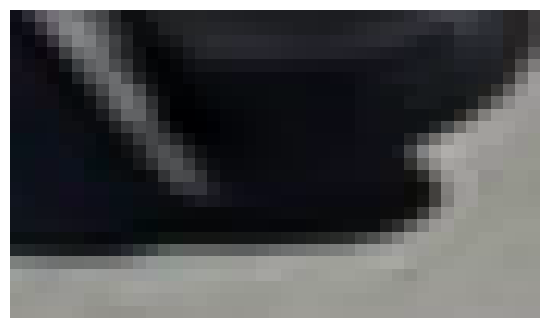

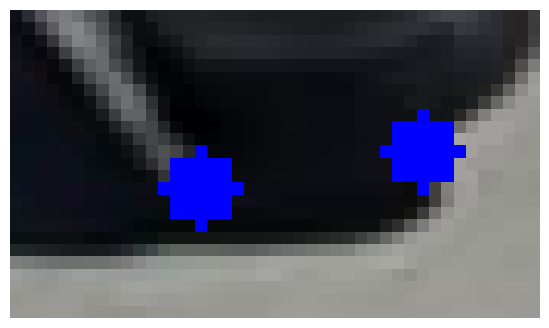

(25, 43)
CPU times: total: 1.28 s
Wall time: 1.09 s


In [26]:
%%time
#run inference for frame1
#then create ROI and find points for measuring object size in pixels

frame1x1, frame1x2, frame1y1, frame1y2, frame1width, frame1height, frame1area, frame1obj = inference(Frame1)
print(frame1x1, frame1x2, frame1y1, frame1y2, frame1width, frame1height, frame1area, frame1obj)

#first need roi for frame1

ROIFrame1 = frame1x1, frame1x2, frame1y1, frame1y2
#print(ROIFrame1pic)

#turn ROI1 into image
x1, x2, y1, y2 = ROIFrame1
x11 =int(x1)
x22 =int(x2)
y11 =int(y1)
y22 =int(y2)
region_of_interestframe1ROI = Frame1[y11:y22, x11:x22]
show_img(region_of_interestframe1ROI)


#then need to run objectpics funtion

#Frame1picobjectpixels, Frame1picerror, Frame1picpoint1x, Frame1picpoint1y, Frame1picpoint2x, Frame1picpoint2y = objectpixs(region_of_interestFrame1picROI)
frame1objectpixels, frame1error, frame1point1x, frame1point1y, frame1point2x, frame1point2y = objectpixs(region_of_interestframe1ROI)


1470.6201 1513.6934 802.8393 822.42206
43.073242 19.582764 843.4931
1
1470.6201 1513.6934 802.8393 822.42206 43.073242 19.582764 843.4931 1


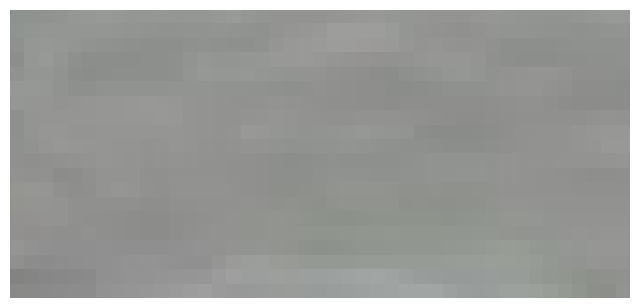

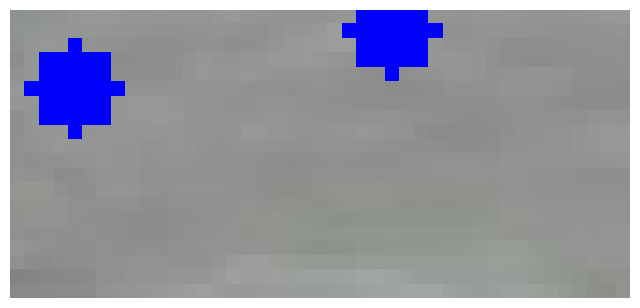

(20, 43)
22.360679774997898
CPU times: total: 1.38 s
Wall time: 1.11 s


In [27]:
%%time
#run infernce and pull data for frame2

frame2x1, frame2x2, frame2y1, frame2y2, frame2width, frame2height, frame2area, frame2obj = inference(Frame2)
print(frame2x1, frame2x2, frame2y1, frame2y2, frame2width, frame2height, frame2area, frame2obj)


#first need roi for frame1

ROIframe2 = frame2x1, frame2x2, frame2y1, frame2y2
#print(ROIFrame1pic)

#turn ROI1 into image
x1, x2, y1, y2 = ROIframe2
x11 =int(x1)
x22 =int(x2)
y11 =int(y1)
y22 =int(y2)
region_of_interestframe2ROI = Frame2[y11:y22, x11:x22]
show_img(region_of_interestframe2ROI)


#then need to run objectpics funtion

#Frame1picobjectpixels, Frame1picerror, Frame1picpoint1x, Frame1picpoint1y, Frame1picpoint2x, Frame1picpoint2y = objectpixs(region_of_interestFrame1picROI)
frame2objectpixels, frame2error, frame2point1x, frame2point1y, frame2point2x, frame2point2y = objectpixs(region_of_interestframe2ROI)
print(frame2objectpixels)

In [28]:
#compare all three ROI images and pixs for the object
print('frame1 from video Pix:', Frame1picobjectpixels)
print('frame1 Pix:', frame1objectpixels)
print('frame2 Pix:', frame2objectpixels)
print('Frame1 from video error:', Frame1picerror)
print('frame1 error:', frame1error)
print('frame2 error:', frame2error)

#Very consistant, need to keep looking at this.  So far so good, use any of them.

frame1 from video Pix: 25
frame1 Pix: 18.24828759089466
frame2 Pix: 22.360679774997898
Frame1 from video error: Too_small
frame1 error: none
frame2 error: none


# Determine pixels per inch

In [29]:
###############Don't think I need this anymore#########################33

#Function to assign the tensor value to the proper object and determine the pixels per inch for the image.
#pass the tensor value from the image and width and height.

def pixperinch1(objectnumber, objpixs):
    objnumber = objectnumber #object number from inference.
    Diameter = df.loc[:,['Diameter']].iloc[objnumber][0] #number in iloc location is the index number from tensor.
    Object = df.loc[:,['Object']].iloc[objnumber][0]

#need to do something to check if width and height are close to square, then use width.  However, hockey puck is an issue.
#try check wich is bigger, width or height.  Use largest as the diamter.  Should work for hockey puck.

    #set width and height
    w = objpixs #abs(x1-x2)
    print(w)
    
    pixsperinch = w/Diameter #if the width is greater than the height, set the pixels per inch on width and diamter of object

    return Diameter, Object, pixsperinch

In [30]:
%%time


###########################This is wrong, should just use object pics function to determine the distance.
#set the diameter, object, and pixelsperinch

#need to add error handling for miss read on corner detection.  Average all measurements without errors###########################

#Frame1picobjectpixels)
#print('frame1 Pix:', frame1objectpixels)
#print('frame2 Pix:', frame2objectpixels)

#frame1diameter, frame1object, frame1pixsperinch = pixperinch1(frame1obj, frame1objectpixels) #pixperinch is defined function
#print('inches', frame1diameter, 'object', frame1object, 'pix/inch', frame1pixsperinch)

#frame2diameter, frame2object, frame2pixsperinch = pixperinch1(frame2obj, frame2objectpixels) #pixperinch is defined function
#print('inches', frame2diameter, 'object', frame2object, 'pix/inch', frame2pixsperinch)

#################frame2 has issue because of the error and defaulting to image size, need error handling for this.
#############maybe if error on any of the images from dots, don't use that one for pix/inch.

#moving along with image one for now.

#######################Need to pick one of these to use for the distance travelled below. For now using frame1pixsperinch.

##create dataframe for objectpixels and error.  Drop error from dataframe and then average the rest.

#create database
error_data = {'Object_Pixs':[Frame1picobjectpixels, frame1objectpixels, frame2objectpixels], 'Error': [Frame1picerror, frame1error, frame2error]}
dferror = pd.DataFrame(data=error_data)
dferror.head()

#drop any records with an error.

no_error = dferror[(dferror['Error'] != "none")].index
dferror.drop(no_error, inplace=True)
dferror.head()
mean_pixs = dferror.loc[:, 'Object_Pixs'].mean()
print(mean_pixs)
Diameter = df.loc[:,['Diameter']].iloc[objnum][0] #number in iloc location is the index number from tensor.

pixsperinch = mean_pixs/Diameter #if the width is greater than the height, set the pixels per inch on width and diamter of object
print(pixsperinch)

########################Need error handling if all an error, then average the object pixs################################################
    

20.304483682946277
6.768161227648759
CPU times: total: 31.2 ms
Wall time: 7.46 ms


# Determine distance travelled by the object

In [31]:
#Zoom(region_of_interest1)
#Zoom(region_of_interest2)

################select the image with the best ratio to use#########################
#Can also look at rating blur to determine which to use for pix/inch.

#maybe take the one that is less blurry.  Also need to compare width to height

#maybe something from each width and height.

#not sure about how to handle puck on edge.  Have to use ratio and based on that determine which to use height or width for pix/inch.

#frame2 is usually better because the stick distorts the image on frame1.  Try using frame2 and then improve detection from ROI images.  Shadows mess with it
#well lit room is much better than dark basement.

In [32]:
%%time
########################Need to rework this with the points from ROIs#######################################33

#interestingly enough, this one is in the y direction.  Need something to determine if it is travelling in x or y direction

#determine if the object is moving in the x or y direction.

######################Need something here########################

###################################Need to rework with frame1pic as opposed to frame1#######################################
############This will eliminate one inference to speed up process

xtravel = abs(frame1x1 - frame2x1) #distance traveled in x direction
print(xtravel, 'xtravel')
ytravel = abs(frame1y1 - frame2y1) #distance traveled in the y direction
print(ytravel, 'ytravel')

if xtravel > ytravel:
    #need to determine which direction on x axis it is going.  Want to get the front of the ball in case of blur
    #############Need to implement above########################################and test on x, looks like it works on y.
    if frame1x1 < frame2x1:
        #update here with points from roi
        #need to update images with points on them for reference to actual

        #####################################Need to think about how this will work############################
        ######   Can't use roi because it doesn't reference the distance travelled with the points.############
        dist = abs(frame1x2-frame2x2)
        print('x2 is head')
    else:
        dist = abs(frame1x1-frame2x1)
        print('x1 is head')
    #dist = abs(frame1x2-frame2x2)
    print('travel in x direction')
else:
    if frame1y1 < frame2y1:
        dist = abs(frame1y1-frame2y1)
        print('y2 is head', 'moving down')
    else:
        dist = abs(frame1y2-frame2y2)
        print('y1 is head', 'moving up')
    #dist = abs(frame1y1-frame2y1) #need to determine direction for same reason as above.
    print('travel in y direction')
    
#also need something to determine center, right now using the lower of the two points, x or y.  Should be the leading point
#in order to account for any blur in image 2.  need to develop this.

print(dist)

#determine distance in inches travelled.  Doing manually for now, but needs to tie to dataframe with size and tensor value.

#travel distance in inches

#travel = dist/frame1pixsperinch #using frame 1 as should have minimal blurring.
#travel = dist/frame2pixsperinch ##########################testing 2/17/24
travel = dist/pixsperinch #frame2pixsperinch # used ppinch before manually entering 16.8############################################

print(round(travel, 2), "inches")

429.8186 xtravel
23.848938 ytravel
x2 is head
travel in x direction
430.4602
63.6 inches
CPU times: total: 0 ns
Wall time: 0 ns


# Determine time of travel between images

In [33]:
#need to remove data info from images, but going to use 0 and 70 for this one, in manual.


#produce frame number based on name of file.
#start = time_stamp(frame1path) #time stamp function to get frame number from file name
#end = time_stamp(frame2path) #time stamp function to get frame number from file name

start = Frame1Noint #time stamp function to get frame number from file name
end = Frame2number #time stamp function to get frame number from file name

timetravel = (end - start)/fps #used 200 for slow mow, need to see why I can't read this from file.

print(round(timetravel, 2), 'time of travel in seconds')

0.05 time of travel in seconds


# Determine mph or kmhr

In [34]:
inpersec = travel/timetravel

print(inpersec, "inches per second")

# 1 inch/sec equals 0.0568182 mph

mph = inpersec*0.0568182


print(round(mph, 2), "mph")

1269.0130425521565 inches per second
72.1 mph


# Output speed and two photos with exploded view of impact

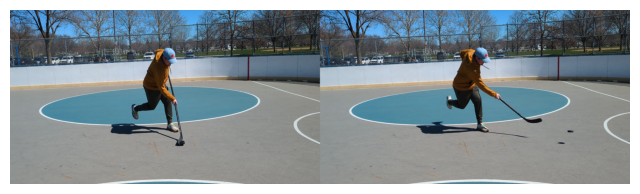

(1040.8015, 1083.2332, 826.68823, 851.6336)
CPU times: total: 906 ms
Wall time: 984 ms


tuple

In [35]:
%%time
#show image 1 with ROI around object exploded horizontally and overight mph on images

# horizontally concatenates images 
# of same height

#need to break out ROI for frame1 based on bounding box co-ordinates.  Start with a % increase for testing
roipercent = 1.2 #increase area around ROI by this much
ROI = frame1x1, frame1x2, frame1y1, frame1y2
#ROIscaled = roipercent * ROI
im_h = np.hstack([Frame1, Frame2])

#########Need better model to get a predictable ROI
  
# show the output image 
show_img(im_h)
print(ROI)
type(ROI)
#print(ROIscaled)


1136
274
(1080, 3840, 3)
72.1MPH


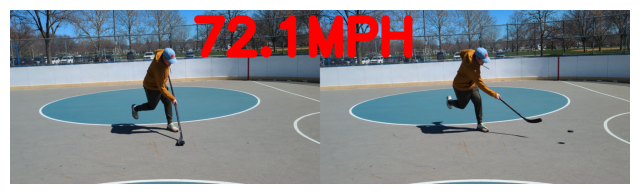

CPU times: total: 953 ms
Wall time: 994 ms


In [36]:
%%time

#write on image
     
# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
  
# org 
textx = int(im_h.shape[0]/.95) #2.625
print(textx)

texty = int(im_h.shape[1]/14) #5
print(texty)
#org = (400, 750) #set placement of text.  first number is X direction, second is y. Need to tie this to the shape of the image 200, 1000
org = (textx, texty)

# fontScale 
fontScale = 10 #was 20
   
# Blue color in BGR 
color = (0, 0, 255) 
  
# Line thickness of 2 px 
thickness = 50

print(im_h.shape)
###########################3shape changes-Need a way to deal with this##################################3

#convert integer to string for placement in image
mphtext = str(round(mph,2)) + "MPH"
print(mphtext)

# Using cv2.putText() method 
image = cv2.putText(im_h, mphtext, org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
   
# Displaying the image 
show_img(image)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


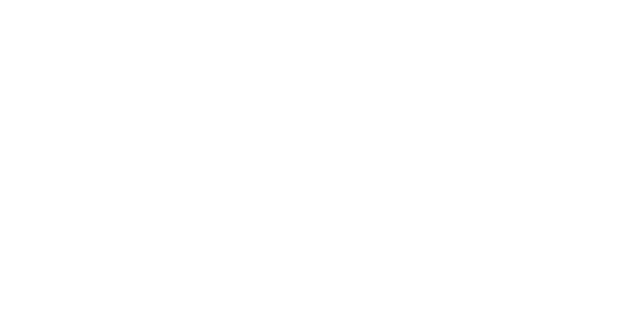

In [37]:
frame10path = 'C:/Users/adamb/Documents/Slapper_Tracker/PXL_20240428_180843959.jpg'
#frame2path = 'C:/Users/adamb/Documents/Slapper_Tracker/2024-02-10frame1750.jpg'

frame10 = cv2.imread(frame10path)
#frame2 = cv2.imread(frame2path)
show_img(frame10)
#show_img(frame2)

Frame1picx1, Frame1picx2, Frame1picy1, Frame1picy2, Frame1picwidth, Frame1picheight, Frame1oucarea, Frame1picobj = inference(frame10)

In [ ]:
#create function to save roi images with an incrementing filename for future testing.

def save_roi(ROIimg):
    i = 0
    while os.path.exists("C:/Users/adamb/Documents/Slapper_Tracker/roi/roi%s.jpg" % i):
        i += 1

    roiimg = ("C:/Users/adamb/Documents/Slapper_Tracker/roi/roi%s.jpg" % i)
    print(roiimg)
    cv2.imwrite(roiimg,ROIimg) #save image

In [ ]:
#create function to save frame images with an incrementing filename for future testing and training data.

def save_frame(Frameimg):
    i = 0
    while os.path.exists("C:/Users/adamb/Documents/Slapper_Tracker/Frames/frame%s.jpg" % i):
        i += 1

    frameimg = ("C:/Users/adamb/Documents/Slapper_Tracker/Frames/frame%s.jpg" % i)
    print(frameimg)
    cv2.imwrite(frameimg,Frameimg) #save image

In [ ]:
#Need to fix so they don't have corners saved on them.

#save_roi(Frame2[y11:y22, x11:x22])
#save_roi(Frame1[y11:y22, x11:x22]) #might need to do something with this as I think frame 2 overwrites frame 1 x and y coordinates.
#save_roi(region_of_interestFrame1picROI)
save_frame(Frame2)
save_frame(Frame1)
save_frame(Frame1pic)


# Items to work on
    1. How to tell if it is moving in X or Y direction-done
    2. Model needs to get better-done
    3. Better nomenclature for x dimensions.-done
    4. How to know when to start/stop or select the two images.
    5. Compare image one detection with image 2 detection
    6. Test with a harder kicked ball and compare.
    7. Upload photos generated from this to model.
    8. Work on output of two pictures with ROI exploded.
    9.Need to create d2go model and utilize for better idea of model on phone.
    10. Need to utilize ROI to determine pix/inch
    11. How to select best frame for measuring pix/inch
    12. Clean up code.
    13. Add timer to see biggest hold-ups and areas of improvement.

In [ ]:
#determine frames per second
##############Need to change to frame1 path
#frame1path = 'C:/Users/adamb/Documents/Slapper_Tracker/2024-02-06frame300.jpg'
frame1path = 'C:/Users/adamb/Documents/Slapper_Tracker/2024-03-03frame42.jpg'
frame2path = 'C:/Users/adamb/Documents/Slapper_Tracker/2024-03-03frame45.jpg'
#frame2path = 'C:/Users/adamb/Documents/Slapper_Tracker/PXL_20240218_180058935.jpg'

frame1 = cv2.imread(frame1path)
frame2 = cv2.imread(frame2path)
show_img(frame1)
show_img(frame2)

#Take first frame

#take frame 20 or something

In [ ]:
#COLLECT DATA FROM TEST AND PUT INTO A DATAFRAME FOR FUTURE ANALYSIS WITH SUPERVISED LEARNING

#create record for dataframe
data = [[object1, ratio1, ratio2, area1, area2, width1, width2, height1, height2, frame1pixsperinch, frame2pixsperinch, xtravel, ytravel, dist, travel, timetravel, fps, mph]]
#print(data)

#create data frame
df = pd.DataFrame(data, columns=['Object', 'Ratio1', 'Ratio2', 'area1', 'area2', 'width1', 'width2', 'height1', 'height2', 'frame1pixsperinch', 'frame2pixperinch', 'xtravel', 'ytravel', 'dist(pixels)','travel(inches)', 'timetravel(sec)', 'fps', 'mph'])
#print(df)

df.head()

#create csv file for dataframe.

In [ ]:
#create csv file from data frame.
dfpath = 'C:/Users/adamb/Documents/Slapper_Tracker/trackerdata.csv' #path to csv file

#read existing data
dfexisting = pd.read_csv(dfpath)

dftest = conc_and_rename(dfexisting, df)

#save to file
dftest.to_csv(dfpath, index=False)

In [ ]:
pre_process(region_of_interest)

In [ ]:
#this is obsolete
#create ROI image for testing to see if I can get a clearer boundary on it for pixel to inch conversion

#turn ROI into image
x1, x2, y1, y2 = ROI
x11 =int(x1)
x22 =int(x2)
y11 =int(y1)
y22 =int(y2)
#region_of_interest = frame1[y:y+h, x:x+w]
region_of_interest = frame1[y11:y22, x11:x22]
show_img(region_of_interest)
#region_of_interest2 already exists

#increment the roi image name to save in roi folder
i = 0
while os.path.exists("C:/Users/adamb/Documents/Slapper_Tracker/roi/roi%s.jpg" % i):
    i += 1

roiimg = ("C:/Users/adamb/Documents/Slapper_Tracker/roi/roi%s.jpg" % i)
#roiimg = open("C:/Users/adamb/Documents/Slapper_Tracker/roi/roi%s.jpg" % i, "w")
print(roiimg)
#cv2.imwrite('C:/Users/adamb/Documents/Slapper_Tracker/roi/roi.jpg',region_of_interest) #save image
cv2.imwrite(roiimg,region_of_interest) #save image


In [ ]:
%%time
outputs = predictor(Frame1pic)

#look at outputs
object = outputs["instances"].pred_classes
boxes = outputs["instances"].pred_boxes
scores = outputs["instances"].scores

##############Remove this as it is not needed, used for troubleshooting#########
    #Visualize results
v = Visualizer(Frame1pic[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

print(object)
print(boxes)
print('Scores:',scores)

In [ ]:
#test for inference with instance filtering


img = frame2

outputs = predictor(img)

#look at outputs
object = outputs["instances"].pred_classes
boxes = outputs["instances"].pred_boxes
scores = outputs["instances"].scores

#Visualize results
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

print(object)
print(boxes)
print('Scores:',scores)

###################################################################################This worked, need to determine how to filter.
#Also going to have to filter out any objects outside of this.  Thinking take the object closest to center of image.  Filter out all else
#then create mask for the objects filtered out and then pass this mask to image two to filter out the object not of interest.
#sounds good, but need to think about how to actually do it.

idxofClass = [i for i, x in enumerate(list(outputs['instances'].pred_classes)) if x == 2]

classes = outputs["instances"].pred_classes[idxofClass]
scores = outputs["instances"].scores[idxofClass]
boxes = outputs["instances"].pred_boxes[idxofClass]

obj = detectron2.structures.Instances(image_size=(480, 640))

obj.set('pred_classes', classes)
obj.set('scores', scores)
obj.set('pred_boxes', boxes)

#out = v.draw_instance_predictions(obj.to("cpu"))

v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(obj.to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

################################################################################################

#Define the coordintates for the object

y = boxes.tensor.numpy() #convert tensor to array for bounding boxes

x1 = y[0][0]
x2 = y[0][2]
y1 = y[0][1]
y2 = y[0][3]

print(x1, x2, y1, y2)

#area of bounding box

width = abs(x1-x2) #pixels
height = abs(y1-y2) #pixels
area = width * height #pixels squared

######Can add a check for accuracy or puck on edge by comparing width and height.  For ball they should be close, for puck it could be on edge.

   
############Need to product tensor value and assign object based on dataframe above.############################
    #make the object tensor a number for further analysis.
ob = object.numpy() #convert object to array for classes
obj = ob[0]
print(classes)
print(scores)
print(boxes)
print(x1,x2,y1,y2)

In [ ]:
#function to pre-process images

def pre_process(img):
    
    #need to add contrast portion to this.*****
    #added 12/29/23 to enhance image for green portion of the ball issues.
    # converting to LAB color space
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    print('enhanced image')
    show_img(enhanced_img)
    
    #adding this 12/28/23
    rgb_planes = cv2.split(enhanced_img)

    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)
    
    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    
    print('result')
    show_img(result)
    
    print('result norm')
    show_img(result_norm)
    
    #remove the background of the picture
    no_background=remove(result) #changed from img
    
    print('no background')
    show_img(no_background)
    
    #convert to gray
    print("**Gray**")
    gray = cv2.cvtColor(no_background, cv2.COLOR_BGR2GRAY) #no_background
    show_img(gray)

    #blur
    print("**Blur**")
    blur = cv2.bilateralFilter(gray, 15, 100, 17) #default 11,17,17; when first number changed to 100, took a long time to run
    show_img(blur)

    #threshold
    print("**Thresh**")
    value, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    show_img(thresh)
    print(value)

    #test a couple more
    edged = cv2.Canny(thresh, 15, 50) #default 15,50
    wide = cv2.Canny(thresh, 10, 200)
    mid = cv2.Canny(thresh, 30, 150)
    tight = cv2.Canny(thresh, 240, 250)

    print("**edged**")
    show_img(edged)
    print("**wide**")
    show_img(wide)
    print("**mid**")
    show_img(mid)
    print("**tight**")
    show_img(tight)
    
    #closing
    dilation = cv2.dilate(edged, np.ones((5,5), np.uint8))
    closing = cv2.erode(dilation, np.ones((5,5), np.uint8))
    print("**edged**")
    show_img(edged)
    print("**dilation**")
    show_img(dilation) #dilation looks good, need to remove some noise
    print("**closing**")
    show_img(closing)

    #find contours
    conts = cv2.findContours(dilation.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    conts = sorted(conts, key=cv2.contourArea, reverse=True)[:8]

    # find the biggest countour (c) by the area
    c = max(conts, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    len(c)
    print(x,y,w,h)

    # draw the biggest contour (c) in green
    trial=cv2.rectangle(dilation,(x,y),(x+w,y+h),(150,255,0),2)
    trial1=cv2.rectangle(img,(x,y),(x+w,y+h),(150,255,0),16)


    show_img(trial)
    show_img(trial1)


In [ ]:
###############completed above, move down the road.
#create ROI for each image to inspect object closer

ROI1 = frame1x1, frame1x2, frame1y1, frame1y2
ROI2 = frame2x1, frame2x2, frame2y1, frame2y2
print(ROI1)
print(ROI2)

#turn ROI1 into image
x1, x2, y1, y2 = ROI1
x11 =int(x1)
x22 =int(x2)
y11 =int(y1)
y22 =int(y2)
#region_of_interest = frame1[y:y+h, x:x+w]
region_of_interest1 = Frame1[y11:y22, x11:x22]
show_img(region_of_interest1)

#turn ROI2 into image
x21, x22, y21, y22 = ROI2
x211 =int(x21)
x222 =int(x22)
y211 =int(y21)
y222 =int(y22)
#region_of_interest = frame1[y:y+h, x:x+w]
region_of_interest2 = Frame2[y211:y222, x211:x222]
show_img(region_of_interest2)

In [ ]:
#take an image from the video every 30 frames
#don't need this anymore only for creating images for model now.
#Need to move this down to the end

pathtovideo1 = 'C:/Users/adamb/Documents/Slapper_Tracker/Videos'
testvideo1 = "PXL_20240406_185147301.mp4"

#join path and video file together
testvideo_new1=os.path.join(pathtovideo1, testvideo1) #join path for video

today = date.today()#today's date for saving images
format = '%Y-%m-%d' #format the date
string = today.strftime(format) #convert date to string
#change date to string###################3
show_frames = 2
current_frame = 0
margin = 4

#cap = video1
cap = cv2.VideoCapture(testvideo_new1)

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        show_img(frame)
        #cv2.imwrite('C:/Users/adamb/Documents/Slapper_Tracker/More_pics/',img6)
        print(string + 'frame{:d}.jpg'.format(current_frame))
        cv2.imwrite('5_' + string + 'frame{:d}.jpg'.format(current_frame), frame)
        current_frame += 5 # i.e. at 30 fps, this advances one second
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
    else:
        cap.release()
        break
  
   
print('Finished!')


In [ ]:
#############################Probably obsolete, work it to the bottom#######################################################333
############################This should be replaced by new function#########################################################3
#function to determine the best inference to use for pixels to inches.  Some blurring or a hockey stick, cause them to become untrue.
#verify width to height ratio and choose the one closest to 1:1
#different for hockey puck becuase it's not a ball

#def aspect_ratio(width1, height1, object1, width2, height2, object2)

width1 = frame1width
height1 = frame1height
object1 = frame1obj

width2 = frame2width
height2 = frame2height
object2 = frame2obj

#check object and as long as it is not 1 a hockey puck, do this else.

area1 = width1*height1
area2 = width2*height2
ratio1 = width1/height1 #ratio for frame1
ratio2 = width2/height2 #ratio for frame2

print('ratio 1 =', ratio1)
print('ratio 2 =', ratio2)
print('area 1 =', area1)
print('area 2 =', area2)

#object with closer ratio to 1 is the one to use for pixels per inch.

ratiolist = [ratio1, ratio2]
#x = 1
bestpic = min(ratiolist, key=lambda x:abs(x-1))
print('best pic is', bestpic)
#need to determine how to make this ratio1 or ratio2
#then need to determine how to deal with error.  Should be 1, but is .95.  Off by 5%, how to make it.  Width looks good.
#think might need to use direction of travel to determine which direction is best.  Blurring occurs in direction of travel and
#should probably choose the opposite to determine.  Or compare width to height.

print('width 1 =',width1)
print('width 2 =',width2)
print('height 1 =',height1)
print('height 2 =',height2)

#####################################################33
##########
############Need to work on this.  Hockey puck and ball
##    Ball take ratio and use closest to one, then look at direction of travel and use opposite dimension
##    for less blurring.  Need to look at hockey puck.  Will need to pass this to other function for pix/inch


In [ ]:
###############this will become obsolete.  Rewriting using points from ROI######################
#Function to assign the tensor value to the proper object and determine the pixels per inch for the image.
#pass the tensor value from the image and width and height.

def pixperinch(objectnumber, width, height):
    objnumber = objectnumber #object number from inference.
    Diameter = df.loc[:,['Diameter']].iloc[objnumber][0] #number in iloc location is the index number from tensor.
    Object = df.loc[:,['Object']].iloc[objnumber][0]

#need to do something to check if width and height are close to square, then use width.  However, hockey puck is an issue.
#try check wich is bigger, width or height.  Use largest as the diamter.  Should work for hockey puck.

    #set width and height
    w = width
    h = height

    if w > h:
        pixsperinch = w/Diameter #if the width is greater than the height, set the pixels per inch on width and diamter of object
    else:
        pixsperinch = h/Diameter #else use the height for pixelsper inch

    return Diameter, Object, pixsperinch

In [ ]:
#function to zoom in and look at ball to detremine pix/inch.

def Zoom(img):
    #convert to gray
    print("**Gray**")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #no_background
    show_img(gray)

    #threshold
    print("**Thresh**")
    value, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    show_img(thresh)
    print(value)

    #edged
    edged = cv2.Canny(thresh, 15, 50) #default 15,50
    print("**edged**")
    show_img(edged)

    #find contours
    conts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    conts = sorted(conts, key=cv2.contourArea, reverse=True)[:8]

    # find the biggest countour (c) by the area
    c = max(conts, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    len(c)
    print(x,y,w,h)

    # draw the biggest contour (c) in green
    trial=cv2.rectangle(edged,(x,y),(x+w,y+h),(150,255,0),2)

    print("**end result**")
    show_img(trial)

    ratio = w/h #ratio of the image to look for distortion

    print('width',w,'height',h)
    print('ratio', ratio)

#################Need to determine how to choose w or h?##########################################3
#try average the height and width for a ball, not sure what to do with hockey puck yet.

    average = (w+h)/2
    print('Average:', average)
    ppinch = average/3 #calculate pix per inch, need to add object to count for 3.###################################################################
    print('pix/inch',ppinch) #big difference from 20 above.

    #check blurriness of image

    #img = cv2.imread(imgpath)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    value = cv2.Laplacian(gray, cv2.CV_64F).var()
    print('bluriness', value)